# Please Create Your Own Copy

In [1]:
import pandas as pd
import numpy as np

# https://docs.python.org/3/library/os.path.html
import os
# https://scikit-image.org/docs/0.7.0/api/skimage.io.html
import skimage.io
# https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize
import cv2

from PIL import Image

import matplotlib.pyplot as plt

# https://github.com/albumentations-team/albumentations
#import albumentations

In [2]:
CROP_EN = False
CROP_SZ = 128
CROP_NUM = 16

# Paths
BASE_PATH = '/project/data'

image_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

cropped_dir = '/project/yi_data/train_crop_128'

In [3]:
# Load train dataframes
train_df = pd.read_csv('train_512.csv')

In [4]:
def crop_transform(img_id):
    # Load image and mask
    img_path = os.path.join(image_dir, f'{img_id}.tiff')
    img = skimage.io.MultiImage(img_path)[-1]
    msk_path = os.path.join(mask_dir, f'{img_id}_mask.tiff')
    msk = skimage.io.MultiImage(msk_path)
    has_msk = False if len(msk) == 0 else True
    
    # Calculate padding of image spatial size
    pad_h = (CROP_SZ - img.shape[0]%CROP_SZ) % CROP_SZ
    pad_w = (CROP_SZ - img.shape[1]%CROP_SZ) % CROP_SZ
    #print(f'Pad size {pad_h}, {pad_w}')
    
    # Pad white color to the image
    img = np.pad(img, [(pad_h//2,pad_h-pad_h//2), (pad_w//2,pad_w-pad_w//2), (0,0)], constant_values=255)
    #plt.imshow(img)
    # Slice image to a list of desired patch size
    img = img.reshape(img.shape[0]//CROP_SZ, CROP_SZ, img.shape[1]//CROP_SZ, CROP_SZ, 3)
    img = img.transpose(0,2,1,3,4).reshape(-1,CROP_SZ,CROP_SZ,3)
    
    if has_msk:
        msk = msk[-1]
        # Pad black color to the mask
        msk = np.pad(msk, [(pad_h//2,pad_h-pad_h//2), (pad_w//2,pad_w-pad_w//2), (0,0)], constant_values=0)
        # Slice mask to a list of desired patch size
        msk = msk.reshape(msk.shape[0]//CROP_SZ, CROP_SZ, msk.shape[1]//CROP_SZ, CROP_SZ, 3)
        msk = msk.transpose(0,2,1,3,4).reshape(-1, CROP_SZ, CROP_SZ, 3)        
        
    if len(img) < CROP_NUM:
        img = np.pad(img, [(0, CROP_NUM-len(img)),(0,0),(0,0),(0,0)], constant_values=255)
        if has_msk:
            msk = np.pad(msk, [(0, CROP_NUM-len(msk)),(0,0),(0,0),(0,0)], constant_values=0)
            assert len(img)==len(msk)
    # Sort patches according to the percentage of biopsy
    img_idxs = np.argsort(img.reshape(img.shape[0],-1).sum(axis=-1))
    #msk_idxs = np.argsort(msk.reshape(msk.shape[0],-1).sum(axis=-1))
    #plt.imshow(msk[img_idxs[0]][:,:,0])
    
    res = []
    for i in range(CROP_NUM):
        res.append({'index': i, 'image': img[img_idxs[i]], 'mask': None})
    return res

In [5]:
if CROP_EN:
    patch_color_mean = []
    patch_color_square = []
    for img_id in train_df.image_id:
        result = crop_transform(img_id)
        for res in result:
            idx, img, msk = res['index'], res['image'], res['mask']
            """https://stackoverflow.com/questions/42406338/why-cv2-imwrite-changes-the-color-of-pics"""
            cv2.imwrite(f'{cropped_dir}/{img_id}_{idx}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            # Use same index from sorted image patches
            if msk is not None:
                cv2.imwrite(f'{cropped_dir}/{img_id}_mask_{idx}.png', cv2.cvtColor(msk, cv2.COLOR_RGB2BGR))
            # Track the statistics for each patch
            patch_color_mean.append((img/255.0).reshape(-1,3).mean(0))
            patch_color_square.append(((img/255.0)**2).reshape(-1,3).mean(0))
    #msk_path = os.path.join(cropped_dir, f'{img_id}_mask_0.png')
    #msk = skimage.io.MultiImage(msk_path)[-1]
    #plt.imshow(msk[:,:,0])

In [ ]:
img_avg = np.array(patch_color_mean).mean(0)
img_std = np.sqrt(np.array(patch_color_square).mean(0) - img_avg**2)
print('Mean: ', img_avg)
print('Std: ', img_std)

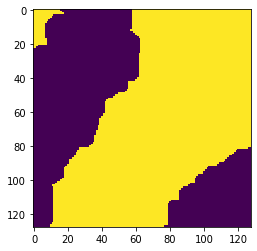

In [7]:
plt.imshow(msk[:,:,0])

[41 42 21 22 23 24 25 35 38 29 30 31 44 43 37 28 17 18 15 51  2  3  4  5
 50 16 36  9 10 11 12 49 48  8  6 45 19  0 47 34 27 53 32 52 14  1 13 26
 39 20 40  7 46 33]


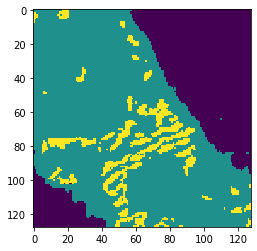

In [21]:
print(msk_idxs)
plt.imshow(msk[msk_idxs[-1]][:,:,0])

In [23]:
cv2.imwrite(f'{cropped_dir}/{train_df.image_id[0]}_0.png', img[idxs[0]])
cv2.imwrite(f'{cropped_dir}/{train_df.image_id[0]}_mask_0.png', msk[msk_idxs[-1]])

True